In [1]:
import csv
import datetime
import os   
import tempfile

from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchvision.models import resnet18
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose

import ray
from ray.train import ScalingConfig, RunConfig
from ray.train.torch import TorchTrainer

### Ray Train provisions the underlying infrastructure via Ray’s cluster autoscaler.

In [2]:
from tqdm.notebook import tqdm
from pathlib import Path
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

def train_loop_torch(num_epochs: int = 2, batch_size: int = 128, local_path: str = "./checkpoints"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    criterion = CrossEntropyLoss()
    model = load_model_torch().to(device)
    optimizer = Adam(model.parameters(), lr=1e-5)
    data_loader = build_data_loader_torch(batch_size=batch_size)

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_loss = 0.0

        for images, labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(data_loader)

        metrics = report_metrics_torch(loss=avg_loss, epoch=epoch)
        Path(local_path).mkdir(parents=True, exist_ok=True)
        save_checkpoint_and_metrics_torch(metrics=metrics, model=model, local_path=local_path)

In [3]:
!pwd

/home/ozkan/Desktop/Anyscale-ray/ray-anyscale/Notebooks


In [4]:
def build_resnet18():
    model = resnet18(num_classes=10)
    model.conv1 = torch.nn.Conv2d(
        in_channels=1, # grayscale MNIST images
        out_channels=64,
        kernel_size=(7, 7),
        stride=(2, 2),
        padding=(3, 3),
        bias=False,
    )
    return model

In [5]:
def load_model_torch() -> torch.nn.Module:
    model = build_resnet18()

    # Move to the GPU device if available, otherwise use CPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    return model

In [6]:
dataset = MNIST(root="./data", train=True, download=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.24MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 216kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.04MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.89MB/s]


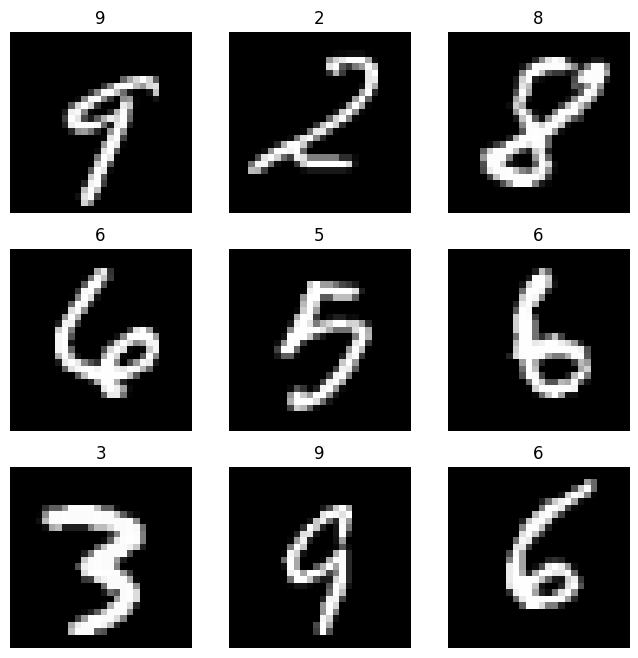

In [8]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(0, len(dataset.data))
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")

In [9]:
def build_data_loader_torch(batch_size: int) -> torch.utils.data.DataLoader:
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    dataset = MNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return train_loader

In [10]:
def report_metrics_torch(loss: torch.Tensor, epoch: int) -> None:
    metrics = {"loss": loss, "epoch": epoch}
    print(metrics)
    return metrics

In [11]:
def save_checkpoint_and_metrics_torch(metrics: dict[str, float], model: torch.nn.Module, local_path: str) -> None:

    # Save the metrics
    with open(os.path.join(local_path, "metrics.csv"), "a") as f:
        writer = csv.writer(f)
        writer.writerow(metrics.values())

    # Save the model
    checkpoint_path = os.path.join(local_path, "model.pt")
    torch.save(model.state_dict(), checkpoint_path)

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
storage_folder = "/mnt/cluster_storage" 
local_path = f"{storage_folder}/torch_{timestamp}/"

In [ ]:
train_loop_torch(
    num_epochs=3,
    local_path=local_path
)

In [ ]:
!ls -l {local_path}

In [ ]:
metrics = pd.read_csv(
    os.path.join(local_path, "metrics.csv"),
    header=None,
    names=["loss", "epoch"],
)

metrics

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model = build_resnet18()
loaded_model.load_state_dict(torch.load(os.path.join(local_path, "model.pt")))
loaded_model.to(device)
loaded_model.eval()

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(0, len(dataset.data))
    img, label = dataset[sample_idx]
    normalized_img = Normalize((0.5,), (0.5,))(ToTensor()(img))
    normalized_img = normalized_img.to(device)

    # use loaded model to generate preds
    with torch.no_grad():        
        prediction = loaded_model(normalized_img.unsqueeze(0)).argmax().cpu()

    figure.add_subplot(rows, cols, i)
    plt.title(f"label: {label}; pred: {int(prediction)}")
    plt.axis("off")
    plt.imshow(img, cmap="gray")